# 基础因子加alpha191回测结果

添加费后曲线

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
import pandas as pd
from PyFin.api import *
from alphamind.api import *
from src.conf.models import *
from datetime import datetime, timedelta
import sqlite3
import numpy as np
from alphamind.execution.naiveexecutor import NaiveExecutor
from matplotlib import pyplot as plt
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [2]:
# 调仓记录
con = sqlite3.connect('./tune_record.db')
sql = 'select * from tune_record_strict'
tune_record = pd.read_sql(sql, con)

In [3]:
 ##--------------因子组合回测--------------
import json
import pdb
from rqalpha.api import *
from rqalpha import run_func
class DailyDefaultStrategy(object):
    def __init__(self, session, stock_sets_ob):
        self._stock_sets_ob = json.loads(stock_sets_ob)
        self._session = session
        self._start_time_str = datetime.now().strftime('%m-%d %H:%M')
    
    
    def init(self,context):
        #读取股票池文件
        context.stock_sets = pd.DataFrame(self._stock_sets_ob)
        context.trade_date_list= list(set(context.stock_sets.trade_date))
        context.holding_stock_df = None
        
        # 是否已发送了order
        context.fired = False

    #盘前处理
    def before_trading(self, context, bar_dict):
        context.trade_signal = False
        date = context.now.date()
        if str(date) in context.trade_date_list:
            context.trade_signal = True

    #盘后处理
    def after_trading(self, context):
        pass
    
    # 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
    def handle_bar(self, context, bar_dict):
        # 开始编写你的主要的算法逻辑
        if context.trade_signal == False:
            return
        date = context.now.date()
        # stock_dict = context.stock_sets.set_index('trade_date').loc[str(date)]
        stock_set = context.stock_sets
        stock_dict = stock_set[stock_set['trade_date'] == str(date)].set_index('trade_date')
        stock_df = self.filter_specials(stock_dict, context)
        #剔除后的股票
        if 'portfolio_weight' in list(set(stock_df.columns)):
            self.rebalance_weight(context, stock_df)
        else:
            self.rebalance_equal(context, stock_df)
   
    def _industry_distribute(self, stock_positions, industries):
        industry_sets_dict = {}
        industries = industries.rename(columns={'symbol':'code'})
        stock_positions = stock_positions.reset_index().rename(
            columns={'symbol':'name','order_book_id':'code','date':'trade_date'})
        stock_positions['trade_date'] = stock_positions['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        industries['trade_date'] = industries['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        stock_positions = stock_positions.merge(industries, on=['trade_date','code'])
        industry_grouped = stock_positions.dropna().groupby(['trade_date'])
        for k, g in industry_grouped:
            gt = g.groupby(['industry_code','industry']).count().reset_index()[['industry_code','industry','code']]
            gt['ratio'] = gt['code']/gt['code'].values.sum()
            gt=gt.rename(columns={'industry':'industry_name'})
            industry_sets_dict[k] = gt[['industry_code','industry_name','ratio']].to_dict(orient='records')
        return industry_sets_dict
    
    def _month_profit(self, portfolio, stock_capital):
        pd.DataFrame(portfolio.reset_index()).shift(1)
        month_profit = portfolio['total_value'].resample('M').mean()
        month_profit = pd.DataFrame(month_profit.reset_index())
        month_profit['last_total'] = month_profit['total_value'].shift(1)
        month_profit = month_profit.fillna(stock_capital)
        month_profit['month_ratio'] = np.log(month_profit.total_value / month_profit.last_total)
        return month_profit.rename(columns={'date':'trade_date'})
    
    def set_result(self, result):
        #summary 结算信息
        summary = result['sys_analyser']['summary']
        #trades 交易记录
        trades = result['sys_analyser']['trades']
        #portfolio 收益曲线
        portfolio = result['sys_analyser']['portfolio']
        # benchmark_portfolio 基础收益曲线benchmark_portfolio
        benchmark_portfolio = result['sys_analyser']['benchmark_portfolio']
        # stock_account 个人收益
        stock_account = result['sys_analyser']['stock_account']
        # stock_positions 股票持仓情况
        stock_positions = result['sys_analyser']['stock_positions']
        
        
    def filter_specials(self, stock_dict, context):
        stock_df = pd.DataFrame(stock_dict)
        stock_list = list(stock_df.code)
        stock_list=[stock for stock in stock_list]
        
        return stock_df.set_index('code').loc[stock_list,:] 
    
    def rebalance_equal(self, context, stock_df):
        holding_list = list(set(stock_df.index))
        if len(holding_list) > 0:
            every_stock = context.portfolio.portfolio_value/len(holding_list) 
        # 空仓只有买入操作
        if len(list(context.portfolio.positions.keys()))==0:
            for stock_to_buy in list(holding_list):
                #print(stock_to_buy)
                order_target_value(stock_to_buy,every_stock)
        else:
            for stock_to_sell in list(context.portfolio.positions.keys()):
                if stock_to_sell not in list(holding_list):
                    order_target_value(stock_to_sell, 0)
            for stock_to_buy in list(holding_list):
                order_target_value(stock_to_buy, every_stock)
                
        
    def rebalance_weight(self, context, stock_df):
        #没有持仓则全部下单
        if len(list(context.portfolio.positions.keys())) == 0:
            weight_sum = stock_df.portfolio_weight.sum()
            every_values = context.portfolio.total_value / weight_sum
            for index, weight in stock_df.iterrows():
                order_target_value(index, weight.portfolio_weight * every_values)
            context.holding_stock_df = stock_df
        else:
            now_df = context.holding_stock_df #当前持有的股票
            # 做交集查看上次实际成交股票
            intersect = list(set(now_df.index).intersection(set(context.portfolio.stock_account.positions.keys())))
            if len(intersect) <= 0:
                now_df = pd.DataFrame({'now_weight':[]})
            else:
                now_df = now_df.loc[context.portfolio.stock_account.positions.keys()]
                now_df = now_df.rename(columns={'portfolio_weight':'now_weight'}) #持仓
            # 做并集
            stock_df = stock_df.rename(columns={'portfolio_weight':'next_weight'}) #调仓
            now_df = pd.merge(now_df, stock_df, left_index=True, right_index=True, how='outer')
            now_df = now_df.fillna(0)
            now_df['diff_weight'] = now_df.next_weight - now_df.now_weight #调仓股票和持仓股票进行对比
            buy_stock = now_df[now_df['diff_weight'] > 0] #当前需买进
            sell_stock = now_df[now_df['diff_weight'] < 0]
            
            # 根据当前权重分配，目的是持仓达到和调仓的权重一样
            weight_sum = stock_df.next_weight.sum()
            every_values = context.portfolio.total_value/ weight_sum
            
            # 平掉不需要股票
            for index, weight in sell_stock.iterrows():
                if weight.now_weight == abs(weight.diff_weight): #全部清仓
                    order_target_value(index, 0)
                else:# 调整权重，此处会有误差，每期的every_values不一样
                    order_target_value(index, weight.diff_weight * every_values)
            # 新建增仓
            for index, weight in buy_stock.iterrows():
                order_target_value(index, abs(weight.diff_weight) * every_values)
            stock_df = stock_df.rename(columns={'next_weight':'portfolio_weight'})
            context.holding_stock_df = stock_df

In [4]:
def ricequant_backtesting(conmbine):
    benchmark_info = '000905.XSHG'
    conmbine = conmbine.copy()
    conmbine['trade_date'] = conmbine['trade_date'].apply(lambda x: x.split(' ')[0] if type(x) is str else x.date().strftime("%Y-%m-%d"))
    #stk_result = stk_data[stk_data['portfolio_weight']>0.001]#.set_index('trade_date').loc['2018-04-12']
    conmbine['code'] = conmbine['code'].apply(lambda x: "{:06d}".format(x) + '.XSHG' 
                                              if len(str(x))==6 and str(x)[0] in '6' 
                                              else "{:06d}".format(x)+ '.XSHE')
    backtesting = DailyDefaultStrategy(1234412, json.dumps(conmbine.to_dict(orient='records')))
    trade_date_list = list(set(conmbine.trade_date))
    trade_date_list.sort(reverse=False)
    base_config = {}
    base_config['start_date'] = trade_date_list[0]
    base_config['end_date'] = trade_date_list[-1]
    base_config['benchmark'] = benchmark_info
            
    accounts_config = {}
    accounts_config['stock'] = 100000000
    base_config['accounts'] = accounts_config
    base_config['frequency'] = '1d'
    base_config['skip_suspended'] = True
    
    extra_config = {}

    mod_config = {}
    sys_analyser_config = {}
    sys_analyser_config['enabled'] = True
    sys_analyser_config['plot'] = True
    mod_config['sys_analyser'] = sys_analyser_config
        
    config = {}
    config['base'] = base_config
    config['extra'] = extra_config
    config['mod'] = mod_config
    result = run_func(init=backtesting.init, before_trading=backtesting.before_trading, 
                  after_trading=backtesting.after_trading, handle_bar=backtesting.handle_bar, config=config)
    return result

2017-01-03 WARN [Deprecated]在before_trading函数中，第二个参数bar_dict已经不再使用了。
2017-01-03 WARN 000973.XSHE 下单量 1764300 超过当前 Bar 成交量的 25.0%，实际成交 1705600.0
2017-01-03 WARN 002498.XSHE 下单量 2690200 超过当前 Bar 成交量的 25.0%，实际成交 1612500.0
2017-01-03 WARN 300122.XSHE 下单量 920900 超过当前 Bar 成交量的 25.0%，实际成交 344000.0
2017-01-03 WARN 订单创建失败: 601168.XSHG 在 2017-01-03 15:00:00 时停牌
2017-01-10 WARN 000631.XSHE 下单量 3158800 超过当前 Bar 成交量的 25.0%，实际成交 1007000.0
2017-01-10 WARN 600563.XSHG 下单量 448500 超过当前 Bar 成交量的 25.0%，实际成交 431200.0
2017-01-10 WARN 600664.XSHG 下单量 2969000 超过当前 Bar 成交量的 25.0%，实际成交 1227300.0
2017-01-17 WARN 000600.XSHE 下单量 1365700 超过当前 Bar 成交量的 25.0%，实际成交 947400.0
2017-01-17 WARN 300324.XSHE 下单量 750800 超过当前 Bar 成交量的 25.0%，实际成交 638600.0
2017-01-17 WARN 订单创建失败: 600645.XSHG 在 2017-01-17 15:00:00 时停牌
2017-01-24 WARN 300324.XSHE 下单量 638600.0 超过当前 Bar 成交量的 25.0%，实际成交 595800.0
2017-01-24 WARN 600112.XSHG 下单量 1194800 超过当前 Bar 成交量的 25.0%，实际成交 939100.0
2017-01-24 WARN 000616.XSHE 下单量 2872800 超过当前 Bar 成交量的 25.0%，实际成交 

2017-07-25 WARN 订单创建失败: 600673.XSHG 在 2017-07-25 15:00:00 时停牌
2017-07-25 WARN 订单创建失败: 601717.XSHG 在 2017-07-25 15:00:00 时停牌
2017-08-01 WARN 订单创建失败: 000662.XSHE 在 2017-08-01 15:00:00 时停牌
2017-08-01 WARN 订单创建失败: 600460.XSHG 在 2017-08-01 15:00:00 时停牌
2017-08-01 WARN 订单创建失败: 600673.XSHG 在 2017-08-01 15:00:00 时停牌
2017-08-08 WARN 000028.XSHE 下单量 303400.0 超过当前 Bar 成交量的 25.0%，实际成交 255700.0
2017-08-08 WARN 订单创建失败: 603077.XSHG 在 2017-08-08 15:00:00 时停牌
2017-08-08 WARN 订单被拒单: [000600.XSHE] 已涨停。
2017-08-08 WARN 订单创建失败: 000662.XSHE 在 2017-08-08 15:00:00 时停牌
2017-08-08 WARN 002004.XSHE 下单量 1995400 超过当前 Bar 成交量的 25.0%，实际成交 1422200.0
2017-08-08 WARN 002332.XSHE 下单量 2676100 超过当前 Bar 成交量的 25.0%，实际成交 1247600.0
2017-08-08 WARN 订单创建失败: 600460.XSHG 在 2017-08-08 15:00:00 时停牌
2017-08-15 WARN 002004.XSHE 下单量 1422200.0 超过当前 Bar 成交量的 25.0%，实际成交 999100.0
2017-08-15 WARN 002332.XSHE 下单量 1247600.0 超过当前 Bar 成交量的 25.0%，实际成交 979300.0
2017-08-15 WARN 000620.XSHE 下单量 1733300 超过当前 Bar 成交量的 25.0%，实际成交 662500.0
2017-08-15 

2018-04-13 WARN 000969.XSHE 下单量 1624300 超过当前 Bar 成交量的 25.0%，实际成交 1556000.0
2018-04-13 WARN 订单创建失败: 002005.XSHE 在 2018-04-13 15:00:00 时停牌
2018-04-13 WARN 订单创建失败: 下单量为0
2018-04-20 WARN 000981.XSHE 下单量 1686200.0 超过当前 Bar 成交量的 25.0%，实际成交 1670000.0
2018-04-20 WARN 订单创建失败: 002437.XSHE 在 2018-04-20 15:00:00 时停牌
2018-04-20 WARN 订单创建失败: 下单量为0
2018-04-27 WARN 订单创建失败: 000766.XSHE 在 2018-04-27 15:00:00 时停牌
2018-04-27 WARN 订单创建失败: 下单量为0
2018-04-27 WARN 订单创建失败: 下单量为0
2018-05-08 WARN 订单被拒单: [000158.XSHE] 已涨停。
2018-05-08 WARN 订单创建失败: 002437.XSHE 在 2018-05-08 15:00:00 时停牌
2018-05-08 WARN 订单创建失败: 300032.XSHE 在 2018-05-08 15:00:00 时停牌
2018-05-08 WARN 订单创建失败: 下单量为0
2018-05-15 WARN 订单创建失败: 002437.XSHE 在 2018-05-15 15:00:00 时停牌
2018-05-15 WARN 订单被拒单: [600614.XSHG] 已涨停。
2018-05-22 WARN 订单被拒单: [300032.XSHE] 已跌停。
2018-05-22 WARN 订单创建失败: 000766.XSHE 在 2018-05-22 15:00:00 时停牌
2018-05-22 WARN 300202.XSHE 下单量 1167600 超过当前 Bar 成交量的 25.0%，实际成交 925800.0
2018-05-29 WARN 300202.XSHE 下单量 925800.0 超过当前 Bar 成交量的 25.0%，实际成

2019-06-17 WARN 订单被拒单: [002437.XSHE] 已涨停。
2019-06-17 WARN 订单创建失败: 下单量为0
2019-06-17 WARN 订单创建失败: 下单量为0
2019-06-24 WARN 002004.XSHE 下单量 2019400 超过当前 Bar 成交量的 25.0%，实际成交 1906900.0
2019-06-24 WARN 002147.XSHE 下单量 6799800 超过当前 Bar 成交量的 25.0%，实际成交 2924400.0
2019-06-24 WARN 订单创建失败: 下单量为0
2019-06-24 WARN 订单创建失败: 下单量为0
2019-07-01 WARN 002212.XSHE 下单量 650800 超过当前 Bar 成交量的 25.0%，实际成交 543500.0
2019-07-01 WARN 订单创建失败: 下单量为0
2019-07-01 WARN 订单创建失败: 下单量为0
2019-07-08 WARN 订单创建失败: 下单量为0
2019-07-08 WARN 订单创建失败: 下单量为0
2019-07-15 WARN 002603.XSHE 下单量 1694300 超过当前 Bar 成交量的 25.0%，实际成交 1226200.0
2019-07-15 WARN 订单被拒单: [300253.XSHE] 已涨停。
2019-07-15 WARN 订单创建失败: 下单量为0
2019-07-22 WARN 订单创建失败: 下单量为0
2019-07-22 WARN 订单创建失败: 下单量为0
2019-07-29 WARN 订单创建失败: 下单量为0
2019-08-05 WARN 订单创建失败: 下单量为0
2019-08-05 WARN 订单创建失败: 下单量为0
2019-08-12 WARN 000766.XSHE 下单量 3150500 超过当前 Bar 成交量的 25.0%，实际成交 1746500.0
2019-08-12 WARN 002212.XSHE 下单量 815200 超过当前 Bar 成交量的 25.0%，实际成交 340800.0
2019-08-26 WARN 002212.XSHE 下单量 340800.0 超过当前 Bar 

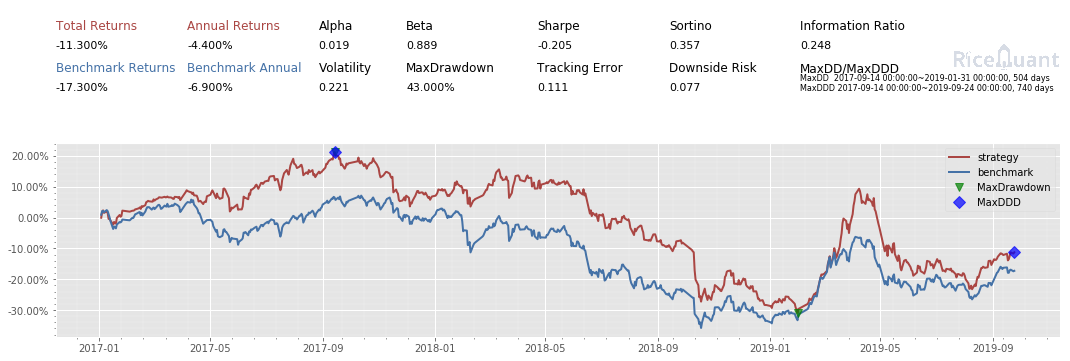

In [5]:
%matplotlib inline
tune_record  = tune_record.rename(columns={'weight':'portfolio_weight'})
# 处理权重小, 直接处理为0
tune_record = tune_record[tune_record['portfolio_weight'] >= 0.05]
result = ricequant_backtesting(tune_record[['trade_date','code','portfolio_weight']])

In [6]:
tune_record

,portfolio_weight,industry,er,code,dx,trade_date
88,0.071590,化工,0.006735,973,0.015756,2017-01-03 00:00:00
140,0.074850,房地产,0.004757,2244,0.015354,2017-01-03 00:00:00
184,0.062940,计算机,0.009701,2410,-0.015676,2017-01-03 00:00:00
201,0.062500,电气设备,0.008295,2498,-0.016087,2017-01-03 00:00:00
242,0.082281,医药生物,0.003632,300122,-0.071973,2017-01-03 00:00:00
298,0.065950,电子,0.004881,600183,0.040955,2017-01-03 00:00:00
450,0.052990,公用事业,0.005610,600917,0.062096,2017-01-03 00:00:00
463,0.061770,有色金属,0.004511,601168,-0.011503,2017-01-03 00:00:00
542,0.069850,房地产,0.006834,631,-0.018407,2017-01-10 00:00:00
554,0.071590,化工,0.006298,703,-0.028920,2017-01-10 00:00:00


# 回测记录

In [7]:
print(result.keys())
record = result['sys_analyser']
print(record.keys())
trade_detail = record['trades']
stock_account = record['stock_account']
stock_positions = record['stock_positions']
stock_positions.head()

2019-09-24 INFO dict_keys(['sys_analyser'])
2019-09-24 INFO dict_keys(['summary', 'trades', 'portfolio', 'benchmark_portfolio', 'stock_account', 'stock_positions'])


,avg_price,last_price,market_value,order_book_id,quantity,symbol
date,,,,,,
2017-01-03,7.58,7.58,12928448.0,000973.XSHE,1705600.0,佛塑科技
2017-01-03,6.97,6.97,13982517.0,002244.XSHE,2006100.0,滨江集团
2017-01-03,14.60,14.60,11757380.0,002410.XSHE,805300.0,广联达
2017-01-03,4.34,4.34,6998250.0,002498.XSHE,1612500.0,汉缆股份
2017-01-03,16.69,16.69,5741360.0,300122.XSHE,344000.0,智飞生物


In [8]:
# 获取指定交易日期的交易记录
trade_detail[trade_detail['trading_datetime'] == '2017-03-28 15:00:00']

,commission,exec_id,last_price,last_quantity,order_book_id,order_id,position_effect,side,symbol,tax,trading_datetime,transaction_cost
datetime,,,,,,,,,,,,
2017-03-28 15:00:00,10065.6400,15712935220087,8.45,1489000.0,002004.XSHE,15712935220992,CLOSE,SELL,华邦健康,12582.050,2017-03-28 15:00:00,22647.6900
2017-03-28 15:00:00,7815.8016,15712935220088,10.44,935800.0,002161.XSHE,15712935220993,CLOSE,SELL,远望谷,9769.752,2017-03-28 15:00:00,17585.5536
2017-03-28 15:00:00,10597.8064,15712935220089,21.46,617300.0,300324.XSHE,15712935220994,CLOSE,SELL,旋极信息,13247.258,2017-03-28 15:00:00,23845.0644
2017-03-28 15:00:00,10325.3360,15712935220090,3.29,3923000.0,600219.XSHG,15712935220995,CLOSE,SELL,南山铝业,12906.670,2017-03-28 15:00:00,23232.0060
2017-03-28 15:00:00,8442.5264,15712935220091,13.09,806200.0,002092.XSHE,15712935221003,OPEN,BUY,中泰化学,0.000,2017-03-28 15:00:00,8442.5264
2017-03-28 15:00:00,10517.3200,15712935220092,21.73,605000.0,002399.XSHE,15712935221013,OPEN,BUY,海普瑞,0.000,2017-03-28 15:00:00,10517.3200
2017-03-28 15:00:00,8984.5176,15712935220093,19.61,572700.0,002405.XSHE,15712935221020,OPEN,BUY,四维图新,0.000,2017-03-28 15:00:00,8984.5176
2017-03-28 15:00:00,9089.5224,15712935220094,16.89,672700.0,300001.XSHE,15712935221028,OPEN,BUY,特锐德,0.000,2017-03-28 15:00:00,9089.5224
2017-03-28 15:00:00,7854.3872,15712935220095,33.44,293600.0,300156.XSHE,15712935221032,OPEN,BUY,神雾环保,0.000,2017-03-28 15:00:00,7854.3872


In [9]:
trade_detail[trade_detail['trading_datetime'] == '2017-03-06 15:00:00']

,commission,exec_id,last_price,last_quantity,order_book_id,order_id,position_effect,side,symbol,tax,trading_datetime,transaction_cost
datetime,,,,,,,,,,,,


In [10]:
# 获取指定交易日的持仓仓位
stock_positions[(stock_positions.index == '2018-12-20') & (stock_positions.quantity != 0)].reset_index()

,date,avg_price,last_price,market_value,order_book_id,quantity,symbol
0,2018-12-20,4.108,2.06,31518.0,002498.XSHE,15300.0,汉缆股份
1,2018-12-20,10.620,5.74,3113950.0,002161.XSHE,542500.0,远望谷
2,2018-12-20,20.105,22.38,2108196.0,002399.XSHE,94200.0,海普瑞
3,2018-12-20,4.280,2.25,3583125.0,600175.XSHG,1592500.0,美都能源
4,2018-12-20,16.664,11.69,2673503.0,603567.XSHG,228700.0,珍宝岛
5,2018-12-20,2.365,1.67,10839535.8,603077.XSHG,6490740.0,和邦生物
6,2018-12-20,5.120,1.20,245160.0,000939.XSHE,204300.0,*ST凯迪
7,2018-12-20,7.125,5.11,7826987.0,000031.XSHE,1531700.0,大悦城
8,2018-12-20,7.840,4.84,2047804.0,002004.XSHE,423100.0,华邦健康
9,2018-12-20,7.640,6.41,1719803.0,002332.XSHE,268300.0,仙琚制药


In [11]:
stock_positions[(stock_positions.index == '2018-12-27') & (stock_positions.quantity != 0)].reset_index()

,date,avg_price,last_price,market_value,order_book_id,quantity,symbol
0,2018-12-27,4.108,1.99,30447.0,002498.XSHE,15300.0,汉缆股份
1,2018-12-27,10.620,5.49,2978325.0,002161.XSHE,542500.0,远望谷
2,2018-12-27,20.105,23.05,2171310.0,002399.XSHE,94200.0,海普瑞
3,2018-12-27,4.280,2.15,3423875.0,600175.XSHG,1592500.0,美都能源
4,2018-12-27,16.664,11.96,2735252.0,603567.XSHG,228700.0,珍宝岛
5,2018-12-27,2.365,1.61,10450091.4,603077.XSHG,6490740.0,和邦生物
6,2018-12-27,5.120,1.15,234945.0,000939.XSHE,204300.0,*ST凯迪
7,2018-12-27,7.125,4.87,7459379.0,000031.XSHE,1531700.0,大悦城
8,2018-12-27,7.840,4.70,1988570.0,002004.XSHE,423100.0,华邦健康
9,2018-12-27,7.640,6.05,1623215.0,002332.XSHE,268300.0,仙琚制药


In [12]:
stock_positions[(stock_positions.index == '2019-01-07') & (stock_positions.quantity != 0)].reset_index()

,date,avg_price,last_price,market_value,order_book_id,quantity,symbol
0,2019-01-07,4.108,2.50,38250.0,002498.XSHE,15300.0,汉缆股份
1,2019-01-07,10.620,5.74,3113950.0,002161.XSHE,542500.0,远望谷
2,2019-01-07,20.105,20.73,1952766.0,002399.XSHE,94200.0,海普瑞
3,2019-01-07,4.280,2.27,3614975.0,600175.XSHG,1592500.0,美都能源
4,2019-01-07,16.664,12.38,2831306.0,603567.XSHG,228700.0,珍宝岛
5,2019-01-07,2.365,1.65,10709721.0,603077.XSHG,6490740.0,和邦生物
6,2019-01-07,5.120,1.19,243117.0,000939.XSHE,204300.0,*ST凯迪
7,2019-01-07,7.125,5.02,7689134.0,000031.XSHE,1531700.0,大悦城
8,2019-01-07,7.840,4.85,2052035.0,002004.XSHE,423100.0,华邦健康
9,2019-01-07,7.640,6.12,1641996.0,002332.XSHE,268300.0,仙琚制药


In [13]:
# trade_detail.to_csv('./trades_record.csv', encoding="utf_8_sig")